In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from dataset_road import stuckDataset

from network import SRUPRS
from utils import my_print, my_save_model, my_load_model, print_metric
from utils import cal_slip_ratio_metric, cal_gaussian_NLL_loss, evaluate
from utils import writeTrainInfo, setup_logger

from torch.utils.data import DataLoader

import json
import os
from datetime import datetime

from torch.optim.lr_scheduler import StepLR

In [2]:
data_keys_cfg_path = '../cfg/data_keys.json'
overall_cfg_path = '../cfg/config.json'
saved_path = '../saved_model/SRUPRS_R2_' + str(datetime.now())

assert os.path.isfile(overall_cfg_path)
with open(overall_cfg_path, 'r') as f:
    cfg = json.load(f)

log_file = os.path.join(saved_path, 'training_log.txt')

roadinfo_mode = cfg["roadinfo_mode"]
batch_size = cfg["batch_size"]
num_epoch = cfg["num_epoch"]
lr = cfg["lr"] 
print_iteration_period = cfg["print_iteration_period"]
loss_weights = cfg["loss_weights"]

In [3]:
train_dataset = stuckDataset(
    road_info=cfg["roadinfo_mode"],
    train_mode=cfg["train_mode"],
    num_sequence=cfg['num_sequence'],
    data_keys_cfg_path=data_keys_cfg_path
)
val_train_dataset = stuckDataset(
    road_info=cfg["roadinfo_mode"], 
    train_mode=cfg["train_mode"],
    num_sequence=cfg['num_sequence'],
    data_keys_cfg_path=data_keys_cfg_path
)
test_dataset = stuckDataset(
    road_info=cfg["roadinfo_mode"],
    train_mode=False,
    test_file='test/*/*.mat',
    num_sequence=cfg['num_sequence'],
    data_keys_cfg_path=data_keys_cfg_path
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=4
)
val_train_loader = DataLoader(
    dataset=val_train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    num_workers=4
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    num_workers=4
)


        Used data keys are ['CAN_DBC_HMC__AWD_01_20ms__AWD_Tq', 'CAN_DBC_HMC__EMS_01_10ms__Eng_rpm', 'CAN_DBC_HMC__YRS_01_10ms__Long_Acc', 'CAN_DBC_HMC__EMS_02_10ms__APS', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_FL', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_FR', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_RL', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_RR', 'RT2502_Stuck__VelocityLevel__VelForward']
        
Data Stacking!
Data Stacking finished!


        Used data keys are ['CAN_DBC_HMC__AWD_01_20ms__AWD_Tq', 'CAN_DBC_HMC__EMS_01_10ms__Eng_rpm', 'CAN_DBC_HMC__YRS_01_10ms__Long_Acc', 'CAN_DBC_HMC__EMS_02_10ms__APS', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_FL', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_FR', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_RL', 'CAN_DBC_HMC__WHL_01_10ms__Wheel_Spd_RR', 'RT2502_Stuck__VelocityLevel__VelForward']
        
Data Stacking!
Data Stacking finished!


        Used data keys are ['CAN_DBC_HMC__AWD_01_20ms__AWD_Tq', 'CAN_DBC_HMC__EMS_01_10ms__Eng_rpm', 'CAN_DBC_HMC__YRS_01_10ms__Long_

In [4]:
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

network = SRUPRS(
    SRUPRS_cfg=cfg['SRUPRS_cfg'],
    data_keys_cfg_path=data_keys_cfg_path
).to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=lr)
scheduler = StepLR(
    optimizer=optimizer,
    step_size=cfg['lr_step_size'],
    gamma=cfg['lr_gamma']
)

cross_entropy_loss_metric = nn.NLLLoss()

In [11]:
CE_loss_list = []
GNLL_loss_list = []
regression_loss_list = []
total_loss_list = []
iteration_len = len(train_dataset)//batch_size
if cfg["train_mode"]:
    if not os.path.exists(saved_path):
        os.makedirs(saved_path)
    
    info_logger = setup_logger("info", log_file)
    info = writeTrainInfo(cfg)
    info_logger.info(info)

    for epoch in range(num_epoch):
        for iteration, items in enumerate(train_loader):
            
            data, pos, road_state_label, slip_ratio_label = items
            data = data.to(device)
            slip_ratio_label, road_state_label = slip_ratio_label.to(device), road_state_label.to(device)
                
            predicted_road_state, slip_mu, slip_std = network.forward(
                data,
                device=device,
                use_detach=False
            )

            CE_loss = cross_entropy_loss_metric(predicted_road_state, road_state_label[:, 0])
            GNLL_loss = cal_gaussian_NLL_loss(
                x=slip_ratio_label,
                mu=slip_mu,
                std=slip_std,
                reduction=True
            )
            regression_loss = torch.mean((slip_mu-slip_ratio_label)**2)
            total_loss = loss_weights[0]*CE_loss + loss_weights[1]*GNLL_loss + loss_weights[2]*regression_loss       
            # total_loss = 0.02*CE_loss + 0.01*GNLL_loss + regression_loss             
            # total_loss = 0.2*CE_loss + 0.02*GNLL_loss + regression_loss
            
            # regression_loss = torch.mean(torch.abs((slip_mu-slip_ratio_label)))
            # total_loss = 0.05*CE_loss + 0.05*GNLL_loss + regression_loss

            CE_loss_list.append(CE_loss.data.item())
            GNLL_loss_list.append(GNLL_loss.data.item())
            regression_loss_list.append(regression_loss.data.item())
            total_loss_list.append(total_loss.data.item())

            if iteration % print_iteration_period == 0:
                
                now_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
                my_print('|{}|Epoch:{:>4}/{:>4}|\tIteration:{:>5}/{}|\tLoss:{:.6f}(CE:{:.4f}, GNLL:{:.4f}, Regression:{:.6f})|lr: {}|'.format(
                    datetime.now(), 
                    epoch, 
                    num_epoch,
                    iteration, 
                    iteration_len, 
                    np.mean(total_loss_list), 
                    np.mean(CE_loss_list), 
                    np.mean(GNLL_loss_list), 
                    np.mean(regression_loss_list),
                    now_lr),
                    log_file=log_file
                )
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        
        if epoch % 1 == 0:
            my_print('###################### Val ###########################', log_file=log_file)
            network.eval()
            for iteration, items in enumerate(val_train_loader):
                
                data, pos, road_state_label, slip_ratio_label = items
                data = data.to(device)                
                slip_ratio_label, road_state_label = slip_ratio_label.to(device), road_state_label.to(device)
            
                with torch.no_grad():
                    predicted_road_state, slip_mu, slip_std = network.forward(
                        data,
                        device=device,
                        use_detach=False
                    )

                metric_dict = evaluate(
                    predicted_road_state,
                    road_state_label,
                    slip_mu,
                    slip_ratio_label
                )

                print_metric(metric_dict, dataset_name='', log_file=log_file)
            
            my_print('----------', log_file=log_file)
                
            for iteration, items in enumerate(test_loader):
                            
                data, pos, road_state_label, slip_ratio_label = items
                data = data.to(device)                
                slip_ratio_label, road_state_label = slip_ratio_label.to(device), road_state_label.to(device)
            
                with torch.no_grad():
                    predicted_road_state, slip_mu, slip_std = network.forward(
                        data,
                        device=device,
                        use_detach=False
                    )

                metric_dict = evaluate(
                    predicted_road_state,
                    road_state_label,
                    slip_mu,
                    slip_ratio_label
                )

                print_metric(metric_dict, dataset_name='Val_', log_file=log_file)                
            
            my_print('###################### Val ###########################', log_file=log_file)
            my_save_model(network, epoch, saved_path)
        network.train()
        scheduler.step()


    Configuration for this experiment
    
        roadinfo_mode : False
        
        train_mode : True
        
        num_sequence : 10
        
        batch_size : 1024
        
        num_epoch : 100
        
        lr : 0.0015
        
        lr_step_size : 3
        
        lr_gamma : 0.98
        
        print_iteration_period : 40
        
        loss_weights : [0.02, 0.01, 1.0]
        
        SRUPRS_cfg :
        
        	ConvLSTM_cfg :
            
        		out_channels : 32
        
        		kernel_size : 3
        
        		stride : 1
        
        		lstm_hidden_dim : 64
        
        		lstm_num_layers : 2
        
        		input_dim : 9
        
        	num_classes : 2
        
        	mlp_hidden_dims : [32, 32]
        
        	p_dropout : 0.3
        

    Configuration for this experiment
    
        roadinfo_mode : False
        
        train_mode : True
        
        num_sequence : 10
        
        batch_size : 1024
        
      

|2021-10-12 13:59:34.487793|Epoch:   0/ 100|	Iteration:    0/188|	Loss:0.226655(CE:-0.5065, GNLL:0.9913, Regression:0.226872)|lr: 0.0015|
|2021-10-12 13:59:35.134807|Epoch:   0/ 100|	Iteration:   40/188|	Loss:0.138950(CE:-0.5326, GNLL:0.7243, Regression:0.142359)|lr: 0.0015|
|2021-10-12 13:59:35.621182|Epoch:   0/ 100|	Iteration:   80/188|	Loss:0.088483(CE:-0.5622, GNLL:0.3754, Regression:0.095972)|lr: 0.0015|
|2021-10-12 13:59:36.017436|Epoch:   0/ 100|	Iteration:  120/188|	Loss:0.060075(CE:-0.5881, GNLL:0.0424, Regression:0.071413)|lr: 0.0015|
|2021-10-12 13:59:36.606109|Epoch:   0/ 100|	Iteration:  160/188|	Loss:0.043094(CE:-0.6052, GNLL:-0.1984, Regression:0.057182)|lr: 0.0015|
###################### Val ###########################
Deep / Recall : 0.692273, Precision : 0.718933, F1: 0.704852
Shallow / Recall : 0.718317, Precision : 0.691624, F1: 0.704219
Accuracy : 0.705035
Slip Ratio / R2 Score : 0.564380, MAE : 0.060869, RMSE : 0.097730
----------
Val_Deep / Recall : 0.641045, Pr

In [6]:
network = my_load_model(model=network, path='../saved_model/SRUPRS_R2_2021-10-12 13_59_31.629019/model_epoch_0070.pt')
network.eval()
for idx, items in enumerate(test_loader):
    data, pos, road_state_label, slip_ratio_label = items
    data = data.to(device)                
    slip_ratio_label, road_state_label = slip_ratio_label.to(device), road_state_label.to(device)

    with torch.no_grad():
        predicted_road_state, slip_mu, slip_std = network.forward(data, device=device, use_detach=False)

    slip_mu = slip_mu.cpu().detach().numpy()
    slip_std = slip_std.cpu().detach().numpy()
    slip_ratio_label = slip_ratio_label.cpu().detach().numpy()

rmse_ = cal_slip_ratio_metric(slip_mu, slip_ratio_label, metric='rmse')
mae_ = cal_slip_ratio_metric(slip_mu, slip_ratio_label, metric='mae')
r2_score_ = cal_slip_ratio_metric(slip_mu, slip_ratio_label, metric='r2_score')

print('rmse : ', rmse_)
print('mae : ', mae_)
print('r2_score : ', r2_score_)

Successfull loaded from ../saved_model/SRUPRS_R2_2021-10-12 13_59_31.629019/model_epoch_0070.pt
rmse :  0.056490593
mae :  0.032387864
r2_score :  0.6796952801986953


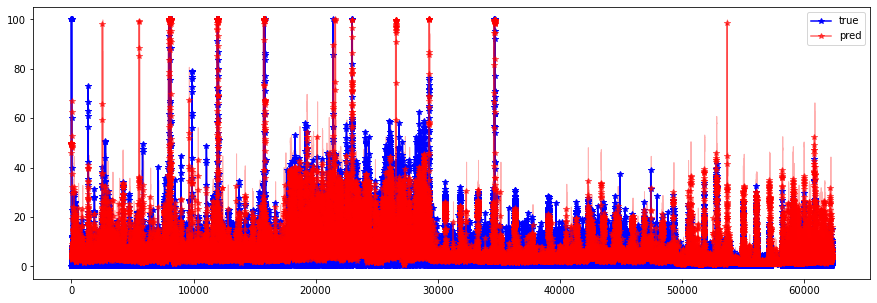

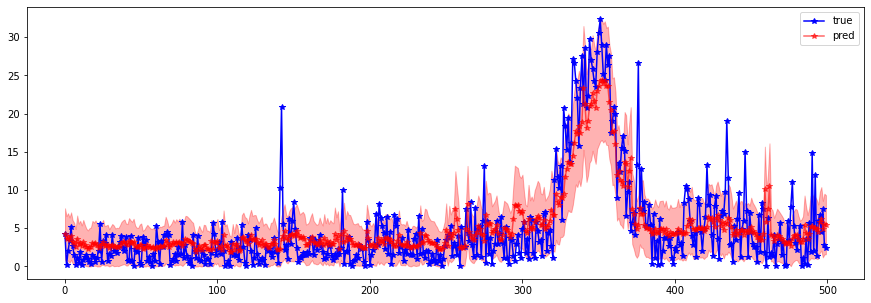

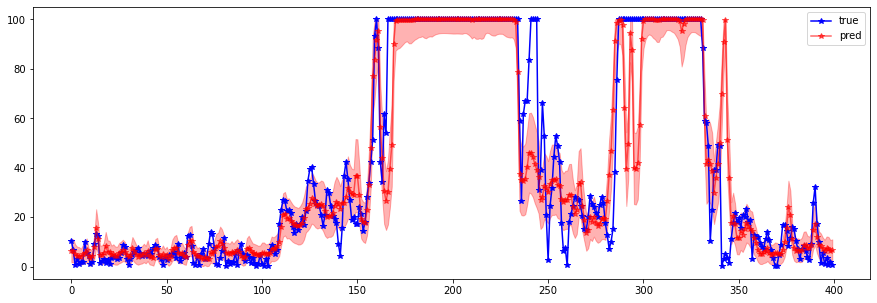

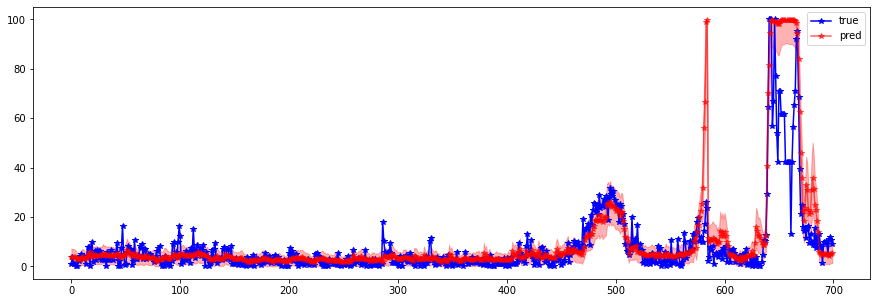

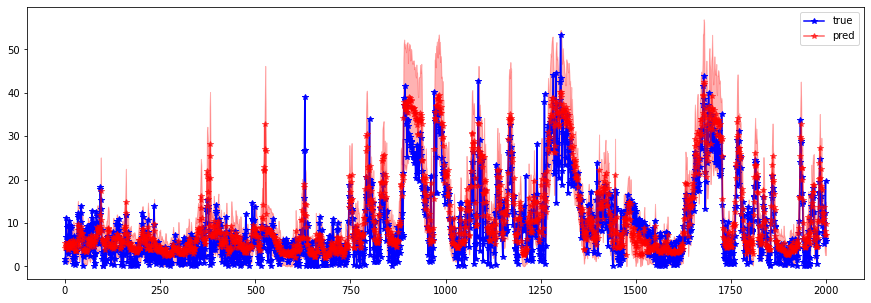

In [9]:
start_list = [0, 31500, 7800, 34000, 17000]
end_plus_list = [len(slip_mu), 500, 400, 700, 2000]
std_scale = 1.0
tire_idx = 1

for start, end_plus_ in zip(start_list, end_plus_list):
    end = start + end_plus_ 

    plt.figure(figsize=(15,5))

    plt.plot(slip_ratio_label[start:end,tire_idx]*100, 'b-*')
    plt.plot(slip_mu[start:end,tire_idx]*100, 'r-*', alpha=0.6)

    lower = np.clip(slip_mu[start:end,tire_idx]*100 - std_scale*slip_std[start:end,tire_idx]*100, a_min=0, a_max=100)
    upper = np.clip(slip_mu[start:end,tire_idx]*100 + std_scale*slip_std[start:end,tire_idx]*100, a_min=0, a_max=100)
    plt.fill_between(np.arange(len(lower)), lower, upper, color='r', alpha=0.3)

    # plt.plot(slip_ratio_label[::1,0]*100, 'bx')
    # plt.plot(slip_mu[::1,0]*100, 'rx')
    plt.legend(['true', 'pred'])
    plt.show()
